In [9]:
import os
os.environ['J_NOTEBOOK'] = '1'

from preprocess.preprocess import *
import PARAMETERS
import sys
sys.path.append('./preprocess/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from confusion_matrix_pretty_print import print_confusion_matrix
from pathlib import Path

%matplotlib inline


PARAMETERS.PREPROCESS_OPTIMIZATION = True

PARAMETERS.LBP_METHOD = 'riu'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False
PARAMETERS.DATASET = 'STARE'

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,riu,get_pyramid_dataset,lanczos,False,5,True,True


In [10]:
# Get CV folds

import pandas as pd
import numpy as np

preprocess = Preprocess(
    lbp_radius=1,
    lbp_method=PARAMETERS.LBP_METHOD,
    height={'DRIVE': 608, 'CHASE': 960, 'STARE': 608}[PARAMETERS.DATASET],
    width={'DRIVE': 576, 'CHASE': 1024, 'STARE': 704}[PARAMETERS.DATASET],
    balance=PARAMETERS.BALANCE
)
masks_path = f'../dataset/{PARAMETERS.DATASET}/training/mask/'
masks = sorted(os.listdir(masks_path))[:14]

n_pixels = {}
for i, mask_path in enumerate(masks):
    mask = preprocess.read_img(masks_path + mask_path)
    n_pixels[i] = np.sum(mask > 100)
    
pixel_ref = {}

for k, v in n_pixels.items():
    upper = np.sum(np.array(list(n_pixels.values()))[:k+1])
    pixel_ref[k] = (upper - n_pixels[k], upper)

cv_folds = {}

for i, j in enumerate(range(0, 14, 3)):
    cv_folds[i] = (pixel_ref[j][0], pixel_ref[min(j+2, 13)][1])

In [11]:
import pandas as pd

df_train = pd.DataFrame()
df_test = pd.DataFrame()

#for conf in ['_blue', '_blue_lbp_gb', '_green', '_green_lbp_gb']:
for conf in ['_blue_lbp_gb', '_green_lbp_gb']:

    df_train_riu = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_train_riu_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')
    df_test_riu = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_test_riu_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')

    df_train_riu.columns = [c + '_riu' if c not in ['Original', 'label'] else c for c in df_train_riu.columns]
    df_test_riu.columns = [c + '_riu' if c not in ['Original', 'label'] else c for c in df_test_riu.columns]

    if df_train.shape[0] == 0:
        y_train = df_train_riu['label']
        y_test = df_test_riu['label']
    df_train_riu = df_train_riu.drop(['label'], axis=1)
    df_test_riu = df_test_riu.drop(['label'], axis=1)


    df_train_var = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_train_var_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')
    df_test_var = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_test_var_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')

    df_train_var.columns = [c + '_var' if c not in ['Original', 'label'] else c for c in df_train_var.columns]
    df_test_var.columns = [c + '_var' if c not in ['Original', 'label'] else c for c in df_test_var.columns]

    df_train_var = df_train_var.drop(['Original', 'label'], axis=1)
    df_test_var = df_test_var.drop(['Original', 'label'], axis=1)

    df_train_temp = pd.concat([df_train_riu, df_train_var], axis=1)
    df_test_temp = pd.concat([df_test_riu, df_test_var], axis=1)
    df_train_temp.columns = [c + conf for c in df_train_temp.columns]
    df_test_temp.columns = [c + conf for c in df_test_temp.columns]

    if df_train.shape[0] > 0:
        df_train_temp.index = df_train.index
        df_test_temp.index = df_test.index
    df_train = pd.concat([df_train, df_train_temp], axis=1)
    df_test = pd.concat([df_test, df_test_temp], axis=1)
    
display(df_train)
display(df_test)

,Original_blue_lbp_gb,1:1_riu_blue_lbp_gb,1:2_riu_blue_lbp_gb,1:4_riu_blue_lbp_gb,1:8_riu_blue_lbp_gb,2:1_1_riu_blue_lbp_gb,2:1_2_riu_blue_lbp_gb,2:1_3_riu_blue_lbp_gb,2:1_4_riu_blue_lbp_gb,1:1_var_blue_lbp_gb,...,2:1_3_riu_green_lbp_gb,2:1_4_riu_green_lbp_gb,1:1_var_green_lbp_gb,1:2_var_green_lbp_gb,1:4_var_green_lbp_gb,1:8_var_green_lbp_gb,2:1_1_var_green_lbp_gb,2:1_2_var_green_lbp_gb,2:1_3_var_green_lbp_gb,2:1_4_var_green_lbp_gb
0,4.0,8.0,8.0,1.0,8.0,8.0,8.0,8.0,8.0,872.571451,...,2.0,8.0,20.086841,387.185103,2785.016150,1191.600705,2.0,1.0,3.0,2.0
1,4.0,8.0,8.0,1.0,8.0,4.0,8.0,4.0,8.0,778.611227,...,16.0,16.0,23.509453,387.185103,2785.016150,1191.600705,0.0,0.0,1.0,1.0
2,5.0,4.0,4.0,1.0,8.0,8.0,8.0,16.0,8.0,1112.249304,...,16.0,34.0,28.386766,432.711552,2785.016150,1191.600705,0.0,0.0,1.0,0.0
3,4.0,16.0,4.0,1.0,8.0,16.0,4.0,8.0,8.0,902.921888,...,27.0,4.0,30.493969,432.711552,2785.016150,1191.600705,0.0,0.0,0.0,2.0
4,4.0,8.0,8.0,0.0,8.0,34.0,8.0,16.0,8.0,996.273178,...,27.0,8.0,26.989399,411.727483,2817.694935,1191.600705,1.0,1.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311427,3.0,1.0,8.0,8.0,4.0,24.0,27.0,0.0,1.0,29.144451,...,35.0,35.0,13.306176,420.247351,591.507191,864.618047,0.0,0.0,0.0,0.0
311428,3.0,34.0,27.0,8.0,4.0,27.0,35.0,2.0,8.0,51.893843,...,35.0,35.0,8.093476,341.418072,591.507191,864.618047,0.0,0.0,0.0,0.0
311429,3.0,34.0,16.0,4.0,16.0,25.0,34.0,11.0,1.0,6.082035,...,2.0,16.0,11.131953,373.351120,489.153997,957.821565,2.0,2.0,1.0,1.0
311430,3.0,16.0,16.0,4.0,16.0,27.0,16.0,1.0,1.0,3.363536,...,16.0,8.0,5.137581,373.351120,489.153997,957.821565,1.0,1.0,1.0,0.0


,Original_blue_lbp_gb,1:1_riu_blue_lbp_gb,1:2_riu_blue_lbp_gb,1:4_riu_blue_lbp_gb,1:8_riu_blue_lbp_gb,2:1_1_riu_blue_lbp_gb,2:1_2_riu_blue_lbp_gb,2:1_3_riu_blue_lbp_gb,2:1_4_riu_blue_lbp_gb,1:1_var_blue_lbp_gb,...,2:1_3_riu_green_lbp_gb,2:1_4_riu_green_lbp_gb,1:1_var_green_lbp_gb,1:2_var_green_lbp_gb,1:4_var_green_lbp_gb,1:8_var_green_lbp_gb,2:1_1_var_green_lbp_gb,2:1_2_var_green_lbp_gb,2:1_3_var_green_lbp_gb,2:1_4_var_green_lbp_gb
0,2.0,35.0,33.0,16.0,16.0,1.0,9.0,35.0,34.0,4.604687,...,24.0,34.0,10.708689,1546.296363,3046.081393,3544.779238,1.0,2.0,2.0,0.0
1,2.0,34.0,34.0,8.0,8.0,4.0,1.0,27.0,35.0,18.642321,...,21.0,8.0,56.261169,509.074406,2867.080741,3345.838388,11.0,3.0,13.0,29.0
2,2.0,8.0,25.0,8.0,8.0,2.0,4.0,34.0,27.0,61.155185,...,27.0,34.0,80.065471,1053.672873,3834.218198,3345.838388,8.0,2.0,10.0,3.0
3,2.0,4.0,25.0,8.0,8.0,34.0,16.0,8.0,4.0,119.229583,...,34.0,35.0,147.403046,1053.672873,3834.218198,3345.838388,2.0,2.0,2.0,1.0
4,2.0,8.0,27.0,8.0,8.0,16.0,8.0,16.0,16.0,159.438298,...,34.0,34.0,116.981709,1354.553495,3834.218198,3345.838388,2.0,2.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312886,5.0,2.0,16.0,4.0,8.0,4.0,4.0,4.0,8.0,841.802942,...,9.0,9.0,9.325836,1601.941506,2208.046090,3093.479551,0.0,0.0,1.0,1.0
312887,3.0,34.0,16.0,4.0,8.0,8.0,16.0,27.0,35.0,401.731709,...,9.0,9.0,14.682778,1601.941506,2208.046090,3093.479551,0.0,0.0,1.0,1.0
312888,4.0,4.0,4.0,4.0,8.0,8.0,8.0,31.0,8.0,1003.352200,...,9.0,9.0,14.451572,1580.386351,2208.046090,3093.479551,0.0,0.0,1.0,1.0
312889,4.0,4.0,4.0,4.0,8.0,8.0,4.0,8.0,4.0,1884.494051,...,9.0,1.0,11.044317,1580.386351,2208.046090,3093.479551,0.0,0.0,1.0,1.0


In [12]:
# CV

from main import init_clf_and_fit
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def cross_validate_features(features, verbose=True):
    f1_list = []
    acc_list = []
    if isinstance(features['y_train'], pd.Series):
        features['y_train'] = features['y_train'].to_frame()
    for k, v in cv_folds.items():
        df_train_temp = pd.concat(
            [features['x_train'].iloc[cv_folds[0][0]:v[0], :],
             features['x_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        y_train_temp = pd.concat(
            [features['y_train'].iloc[cv_folds[0][0]:v[0], :],
             features['y_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        clf = init_clf_and_fit(df_train_temp, y_train_temp.values.ravel(), lgb='Num')
        y_predicted = clf.predict(features['x_train'].iloc[v[0]:v[1], :])
        acc = accuracy_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        acc_list.append(acc)
        f1 = f1_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        f1_list.append(f1)
        mat = confusion_matrix(features['y_train'].iloc[v[0]:v[1], :], y_predicted).ravel()
        if verbose:
            print('Accuracy score: ' + str(acc) + '\n')
            print('F1 score: ' + str(f1) + '\n')
            print('Confusion matrix:\n')
            print_confusion_matrix(features['y_train'].iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
            print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
            print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
            print('-------------------------------------')

    return {'acc': np.mean(acc_list), 'f1': np.mean(f1_list)}


cross_validate_features({'x_train': df_train, 'y_train':y_train})

Accuracy score: 0.9288566677382525

F1 score: 0.5670778469577424

Confusion matrix:

     t/p    0.0   1.0 
      0.0 826068 22893 
      1.0 43719 43627 
Sensivity: 0.49947335882581917
Specificity: 0.9730340969726524
-------------------------------------
Accuracy score: 0.9232636183233073

F1 score: 0.5479649917375604

Confusion matrix:

     t/p    0.0   1.0 
      0.0 843866 19484 
      1.0 54374 44766 
Sensivity: 0.4515432721404075
Specificity: 0.9774320959054844
-------------------------------------
Accuracy score: 0.9499500162340436

F1 score: 0.7603408068079535

Confusion matrix:

     t/p    0.0   1.0 
      0.0 815105 22335 
      1.0 24527 74337 
Sensivity: 0.7519117171063279
Specificity: 0.9733294325563623
-------------------------------------
Accuracy score: 0.9405513934351821

F1 score: 0.7090339813183768

Confusion matrix:

     t/p    0.0   1.0 
      0.0 812867 26500 
      1.0 29165 67823 
Sensivity: 0.6992926960036293
Specificity: 0.9684285896395737
-----------------

{'acc': 0.9365864312893054, 'f1': 0.6612229573993473}

In [13]:
import pickle
from os import listdir

PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/images'
MASK_PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/mask'
LABELS_PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/1st_manual'

def load_images():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][:14]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][:14]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES = load_images()
MASKS = load_masks()

with open(r'/home/fer/Drive/Estudios/Master-IA/TFM/lbp-pyramid/convolution/outputs/16558520630879009_stare/population.pkl', 'rb') as f:
    kernels = pickle.load(f)
    
population, fitness = kernels['population'], kernels['fitness']
individual = population[np.argmax(fitness), :]
n_kernels = 6
k_size = (3, 5, 7)

features = [pd.DataFrame()]*14
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES, MASKS, features)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features = pd.concat(features, ignore_index=True)

conv_features.index = df_train.index

In [14]:
cross_validate_features({
    'x_train': pd.concat([df_train, conv_features], axis=1),
    'y_train': y_train,
})

Accuracy score: 0.9341775720997494

F1 score: 0.6205049261083744

Confusion matrix:

     t/p    0.0   1.0 
      0.0 824292 24669 
      1.0 36961 50385 
Sensivity: 0.5768438165456918
Specificity: 0.9709421280836222
-------------------------------------
Accuracy score: 0.9269758646843084

F1 score: 0.5862643410898345

Confusion matrix:

     t/p    0.0   1.0 
      0.0 842408 20942 
      1.0 49343 49797 
Sensivity: 0.5022896913455719
Specificity: 0.9757433254184282
-------------------------------------
Accuracy score: 0.9514762299424119

F1 score: 0.7767255571663759

Confusion matrix:

     t/p    0.0   1.0 
      0.0 811845 25595 
      1.0 19838 79026 
Sensivity: 0.7993405081728435
Specificity: 0.9694366163546045
-------------------------------------
Accuracy score: 0.9463729034394006

F1 score: 0.7539904171198448

Confusion matrix:

     t/p    0.0   1.0 
      0.0 809191 30176 
      1.0 20038 76950 
Sensivity: 0.7933971212933559
Specificity: 0.9640490989042934
------------------

{'acc': 0.9422414568425352, 'f1': 0.7040631762940857}

In [ ]:
parameters = [22,  7, 66, 75, 39, 72, 35, 35]
PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/images'
MASK_PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/mask'
LABELS_PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/1st_manual'


def load_images():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

P_OBJ = Preprocess(
    lbp_radius=1,
    lbp_method=PARAMETERS.LBP_METHOD,
    height={'DRIVE': 608, 'CHASE': 960, 'STARE': 608}[PARAMETERS.DATASET],
    width={'DRIVE': 576, 'CHASE': 1024, 'STARE': 704}[PARAMETERS.DATASET],
    balance=PARAMETERS.BALANCE
)

IMAGES = [Preprocess.img_processing(img, params=parameters) for img in load_images()]
MASKS = load_masks()

img_df = [pd.DataFrame(img[mask]) for img, mask in zip(IMAGES, MASKS)]

gray_intensity_train = pd.concat(img_df[:14], ignore_index=True)
gray_intensity_train.columns = ['gray_optimized']
gray_intensity_train.index = df_train.index

In [ ]:
cross_validate_features({
    'x_train': pd.concat([df_train, conv_features, gray_intensity_train], axis=1),
    'y_train': y_train,
})

In [15]:
def load_images_test():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][14:]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks_test():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][14:]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES_test = load_images_test()
MASKS_test = load_masks_test()

features_test = [pd.DataFrame()]*14
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features_test = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES_test, MASKS_test, features_test)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features_test = pd.concat(features_test, ignore_index=True)
conv_features_test.index = df_test.index

Columns: Index([  'Original_blue_lbp_gb',    '1:1_riu_blue_lbp_gb',
          '1:2_riu_blue_lbp_gb',    '1:4_riu_blue_lbp_gb',
          '1:8_riu_blue_lbp_gb',  '2:1_1_riu_blue_lbp_gb',
        '2:1_2_riu_blue_lbp_gb',  '2:1_3_riu_blue_lbp_gb',
        '2:1_4_riu_blue_lbp_gb',    '1:1_var_blue_lbp_gb',
          '1:2_var_blue_lbp_gb',    '1:4_var_blue_lbp_gb',
          '1:8_var_blue_lbp_gb',  '2:1_1_var_blue_lbp_gb',
        '2:1_2_var_blue_lbp_gb',  '2:1_3_var_blue_lbp_gb',
        '2:1_4_var_blue_lbp_gb',  'Original_green_lbp_gb',
         '1:1_riu_green_lbp_gb',   '1:2_riu_green_lbp_gb',
         '1:4_riu_green_lbp_gb',   '1:8_riu_green_lbp_gb',
       '2:1_1_riu_green_lbp_gb', '2:1_2_riu_green_lbp_gb',
       '2:1_3_riu_green_lbp_gb', '2:1_4_riu_green_lbp_gb',
         '1:1_var_green_lbp_gb',   '1:2_var_green_lbp_gb',
         '1:4_var_green_lbp_gb',   '1:8_var_green_lbp_gb',
       '2:1_1_var_green_lbp_gb', '2:1_2_var_green_lbp_gb',
       '2:1_3_var_green_lbp_gb', '2:1_4_var_gre

/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


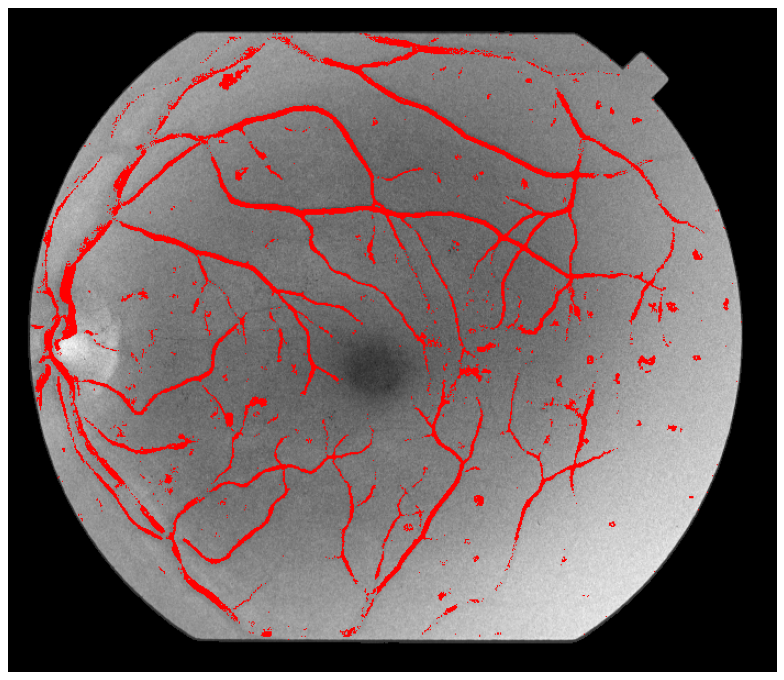

Accuracy score: 0.9381310574975814

F1 score: 0.598897293103926

Confusion matrix:

     t/p    0.0   1.0 
      0.0 1669677 16648 
      1.0 99168 86464 
Sensivity: 0.4657817617652129
Specificity: 0.9901276444339021


(0.938, 0.599, 1669677, 16648, 99168, 86464)

In [19]:
features = {
    'x_train': pd.concat([df_train, conv_features], axis=1),
    'x_test': pd.concat([df_test, conv_features_test], axis=1),
    'y_train': y_train,
    'y_test': y_test
}

from main import main
PARAMETERS.PLOT = True

main(lgb='Num', features=features, plot_once=True, recurrence=True)